In [208]:
import numpy as np
import scipy.stats
import math
import pandas as pd
import random as rnd
from gurobipy import *
import xlsxwriter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Generating affinity matrix, using department partition as shown by Huseyin
rnd.seed(1)
profs = 30 #num professors
num_departments = 5 #num departments
preference_prob = .5 #prob of professor i within department d liking professor j within same department
 
C = np.zeros((profs, profs))

rnd.seed(1)
#partitions = np.random.randint(0,profs,size = num_departments - 1)
partitions = [5, 9, 16, 23]
partitions.sort()
partitions = np.append(partitions,profs)


# last_p = 0
# for p in partitions:
#     C[last_p:p,last_p:p] = np.random.binomial(1,preference_prob, size = (p - last_p,p - last_p))
#     last_p = p

last_p = 0
for p in partitions:
    for prof in range(last_p, p):
        affinities = np.random.randint(last_p,p,size = 2)
        C[prof, affinities] = 1
    last_p = p

for i in range(0,profs):
    C[i,i] = 1
    
print(partitions)
print(C)

[ 5  9 16 23 30]
[[1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1

In [3]:
#generating room preferences

#hard-coded room numbers
second_floor_rooms = [210,212,214,216,220,252,254,255,
                      256,257,259,261,262,263, 264,265,
                      266,268,270,271,273, 291, 293]
    
third_floor_rooms = [int('3' + str(num)[1:]) for num in second_floor_rooms]
third_floor_rooms.remove(391) # remove 391 393
third_floor_rooms.remove(393)
room_list = second_floor_rooms + third_floor_rooms
rooms = len(room_list)
shuffled_rooms = rnd.sample(room_list, rooms)
num_rankings = 3

#R_ is num_professors x num_ranking matrix, R_ik is the kth choice room number for professor i
R_ = np.zeros((profs,num_rankings))

#uniform case: generates room rankings for each professor, assuming all rooms are equally preferred 
# for i in range(profs):
#     R_[i] = np.random.choice(room_list, size=num_rankings, replace=False, p=None)

#weighted case: generates room rankings for each professor, assuming room preferences follow a geometric distribution ~geom(p)  
p = .2
room_probs = [scipy.stats.geom.pmf(k,p) for k in range(1,rooms+1)]
room_probs[-1] = 1 - min(sum(room_probs[:-1]),1)

for i in range(profs):
    R_[i] = np.random.choice(shuffled_rooms, size=num_rankings, replace=False, p=room_probs)
    print(R_[i])
    
#R is num_professors x num_room X num_ranking matrix, 
#R_ijk is 1 if professor i's kth ranked room is the jth element of room_list
R= np.zeros((profs,rooms,num_rankings))
for i in range(profs):
    for j in range(rooms):
        for k in range(num_rankings):
            if R_[i,k]==room_list[j]:
                R[i,j,k]=1
R

[220. 355. 255.]
[266. 363. 352.]
[363. 263. 355.]
[266. 355. 363.]
[356. 256. 363.]
[363. 352. 256.]
[256. 220. 263.]
[220. 363. 266.]
[263. 256. 255.]
[355. 256. 263.]
[356. 363. 256.]
[256. 220. 262.]
[363. 355. 266.]
[352. 255. 220.]
[220. 263. 255.]
[220. 355. 363.]
[266. 255. 220.]
[256. 220. 355.]
[220. 356. 256.]
[255. 256. 266.]
[352. 212. 363.]
[256. 254. 352.]
[266. 220. 263.]
[220. 363. 266.]
[255. 355. 312.]
[220. 363. 212.]
[352. 220. 266.]
[256. 363. 220.]
[352. 355. 316.]
[352. 255. 363.]


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [4]:
floors = 2
lowest_floor = 2
#F is num_professors X num floors matrix where F_il = 1 if professor i wants to sit on floor l
F = np.zeros((profs,floors))
#if professor i chose a room on floor l in his rankings R_, then we assume she wants to sit on that floor
for i in range(profs):
    floor_nums_for_i = [int(str(n)[0]) - lowest_floor for n in R_[i]]
    for l in floor_nums_for_i:
        F[i,l] = 1
F

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 0.],
       [1., 1.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 0.],
       [1., 1.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [1., 1.]])

In [5]:
#import the distance matrix

Distance = pd.read_csv("huddle_distance_csv.csv", index_col= 0, sep=";")
Distance.fillna(value=0, inplace=True)

D = np.array(Distance)


# D = np.zeros( ( rooms , rooms ) )
# for i in range( rooms ):
#     for j in range( i ):
#         if i==j:
#             D[ i ][ j ] = 0
#         elif room_list[i]//100 != room_list[j]//100: # BE CAREFUL!! PYTHON 3 FLOOR DIVISION
#             D[ i ][ j ] = rnd.randint( 101 , 110 )
#             D[j][i] = D[i][j]
#         else:
#             D[ i ][ j ] = rnd.randint( 1 , 10 )
#             D[j][i] = D[i][j]
            
M = np.array([8,4,2])
d = 4
D.shape

(44, 44)

In [ ]:
Distance.loc[210,'261']

In [6]:
# def initializeData():
#     rnd.seed( 1 )
#     room_no = 12
#     prof_no = 10
#     D = np.zeros( ( room_no , room_no ) )
#     for i in range( room_no ):
#         for j in range( room_no ):
#             if i==j:
#                 D[ i ][ j ] = 0
#             elif i%100 != j%100:
#                 D[ i ][ j ] = rnd.uniform( 100 , 110 )
#             else:
#                 D[ i ][ j ] = rnd.uniform( 0 , 10 )
    
#     #Affinity = np.array([[1,1,0,0,0],[1,1,0,0,0],[0,0,1,0,0],[0,1,1,1,0],[0,1,0,0,1]])
    
#     #floors preference
#     return(D)

# def distance( i , j ):
#     global facs , custs
#     dx = facs[ i ][ 0 ] - custs[ j ][ 0 ]
#     dy = facs[ i ][ 1 ] - custs[ j ][ 1 ]
#     val = ( ( dx * dx ) + ( dy * dy ) ) ** 0.5
#     return val

def constructVars():
    global profs , rooms , num_rankings , myModel , xVar
    for i in range( profs ):
        for j in range(rooms):
            xVar[i][j] = myModel.addVar( vtype = GRB.BINARY , ub = 1 , name = "x" + str( i ) + "_" + str(room_list[j]) )
    myModel.update()
    
def constructObj():
    global profs, rooms, num_rankings , myModel, xVar
    objExpr = LinExpr()
    for i in range( profs):
        for k in range(num_rankings):
            for j in range( rooms ):
                objExpr += M[k] * R[i][j][k] * xVar[i][j]
    myModel.setObjective( objExpr , GRB.MAXIMIZE )
    
def constructConstrs():
    global profs, rooms, num_rankings, floors, myModel, xVar
    constrExpr = LinExpr()
    for i in range( profs ):
        for l in range( floors ):  # be careful with where it starts and ends
            constrExpr = LinExpr()
            for j in range( rooms ):
                if room_list[j]>= 100*(l+lowest_floor) and room_list[j]<100*(l+lowest_floor+1):        
                    constrExpr += xVar[ i ][ j ]
            myModel.addConstr( lhs = constrExpr , sense = GRB.LESS_EQUAL , rhs = F[i][l] , name = "prof_" + str( i ) + "_floor_" + str(l+lowest_floor))
    
    for j in range( rooms ):
        constrExpr = LinExpr()
        for i in range( profs ):
            constrExpr += xVar[ i ][ j ]
        myModel.addConstr( lhs = constrExpr, sense = GRB.LESS_EQUAL , rhs = 1 , name= "room_" + str( room_list[j] ) + "_assigned_max_once" )
    
    for i in range( profs ):
        constrExpr = LinExpr()
        for j in range( rooms ): 
            constrExpr += xVar[ i ][ j ]
        myModel.addConstr( lhs = constrExpr, sense = GRB.EQUAL , rhs = 1 , name= "prof_" + str( i ) + "_gets_a_room" )
    
    indices = np.transpose(np.nonzero(C))
    for index in indices:
        if index[0] != index[1]:
            for j in range(rooms):
                for j_prime in range( rooms ): # doesn't need to run through all the rooms, we will have duplicate constraints
                    constrExpr = LinExpr()
                    constrExpr += D[j][j_prime]*(xVar[index[0]][j] + xVar[index[1]][j_prime] - 1)
                    myModel.addConstr( lhs = constrExpr, sense = GRB.LESS_EQUAL , rhs = d , name= "Affinity_prof_" + str( index[0] ) + "_room_" + str(room_list[j]) + "_with_prof_" + str(index[1]) +"_room_"+str(room_list[j_prime]))
    myModel.update()

In [ ]:
### model based on objective function (room & affinity preference)

def constructVars():
    global profs , rooms , num_rankings , myModel , xVar
    for i in range( profs ):
        for j in range(rooms):
            xVar[i][j] = myModel.addVar( vtype = GRB.BINARY , ub = 1 , name = "x" + str( i ) + "_" + str(room_list[j]) )
    myModel.update()
    
def constructObj():
    global profs, rooms, num_rankings , myModel, xVar
    objExpr = LinExpr()
    for i in range( profs):
        for k in range(num_rankings):
            for j in range( rooms ):
                objExpr += M[k] * R[i][j][k] * xVar[i][j]
    myModel.setObjective( objExpr , GRB.MAXIMIZE )
    
def constructConstrs():
    global profs, rooms, num_rankings, floors, myModel, xVar
    constrExpr = LinExpr()
    for i in range( profs ):
        for l in range( floors ):  # be careful with where it starts and ends
            constrExpr = LinExpr()
            for j in range( rooms ):
                if room_list[j]>= 100*(l+lowest_floor) and room_list[j]<100*(l+lowest_floor+1):        
                    constrExpr += xVar[ i ][ j ]
            myModel.addConstr( lhs = constrExpr , sense = GRB.LESS_EQUAL , rhs = F[i][l] , name = "prof_" + str( i ) + "_floor_" + str(l+lowest_floor))
    
    for j in range( rooms ):
        constrExpr = LinExpr()
        for i in range( profs ):
            constrExpr += xVar[ i ][ j ]
        myModel.addConstr( lhs = constrExpr, sense = GRB.LESS_EQUAL , rhs = 1 , name= "room_" + str( room_list[j] ) + "_assigned_max_once" )
    
    for i in range( profs ):
        constrExpr = LinExpr()
        for j in range( rooms ): 
            constrExpr += xVar[ i ][ j ]
        myModel.addConstr( lhs = constrExpr, sense = GRB.EQUAL , rhs = 1 , name= "prof_" + str( i ) + "_gets_a_room" )
    
    indices = np.transpose(np.nonzero(C))
    for index in indices:
        if index[0] != index[1]:
            for j in range(rooms):
                for j_prime in range( rooms ): # doesn't need to run through all the rooms, we will have duplicate constraints
                    constrExpr = LinExpr()
                    constrExpr += D[j][j_prime]*(xVar[index[0]][j] + xVar[index[1]][j_prime] - 1)
                    myModel.addConstr( lhs = constrExpr, sense = GRB.LESS_EQUAL , rhs = d , name= "Affinity_prof_" + str( index[0] ) + "_room_" + str(room_list[j]) + "_with_prof_" + str(index[1]) +"_room_"+str(room_list[j_prime]))
    myModel.update()

In [7]:
## integer programming optimization
# ( noFacs , noCusts , facs , custs , fixs , caps , dems ) = initializeData()
myModel = Model( "seat assignment" )
# yVars = [ 0 for i  in range( noFacs ) ]
# xVars = [ [ 0 for j in range ( noCusts ) ] for i in range ( noFacs ) ]
xVar = np.empty([profs,rooms], dtype=Var)
constructVars()
constructObj()
constructConstrs()
myModel.write( "seat_assignment.lp" )
myModel.optimize()
print('optimal objective: {}'.format(myModel.ObjVal))
print('optimal solution:')
allVars = myModel.getVars()
for curVar in allVars:
    if curVar.x == 1:
        print(curVar.varName + '  ' + str(curVar.x))

Academic license - for non-commercial use only
Optimize a model with 94998 rows, 1320 columns and 189376 nonzeros
Variable types: 0 continuous, 1320 integer (1320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e+00, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 14.0000000
Presolve removed 94832 rows and 539 columns
Presolve time: 0.18s
Presolved: 166 rows, 781 columns, 3934 nonzeros
Variable types: 0 continuous, 781 integer (781 binary)

Root relaxation: objective 8.200000e+01, 41 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      82.0000000   82.00000  0.00%     -    0s

Explored 0 nodes (41 simplex iterations) in 0.24 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 82 14 

Optimal solution found (t

In [155]:
### visualization ###

# creating list with room assignment for each professor
room_assignment = np.zeros((profs,3), dtype=int)

# room_assignment['172']['Happiness']
prof = 0
for curVar in allVars:
    if curVar.x == 1:
        room_assignment[prof,0] = prof 
        room_assignment[prof,1] = int(curVar.varName[-3:])
        try:
            room_assignment[prof,2]= np.nonzero(R_[prof]==room_assignment[prof,1])[0][0] + 1
        except:
            room_assignment[prof,2] = 4
        prof += 1
        
floor2_layout = [210,212,214,216,220,252,254,256,262,264,266,268,270,255,257,259,261,263,265,271,273,291,293]
floor3_layout = [310,312,314,316,320,352,354,356,362,364,366,368,370,355,357,359,361,363,365,371,373]
        
key_list = [x for x in (floor2_layout+floor3_layout)]

### create a dictionary of rooms-professor-happiness for future use if necessary

happiness_list, prof_list = get_ordered_happiness_profs(room_assignment, key_list)

room_happiness = dict(zip(key_list, happiness_list))
room_prof = dict(zip(key_list, prof_list))

print('Room happiness:', room_happiness)
print('\nRoom profs:', room_prof)

# room_assignment_dict = {}
# for k in key_list:
#     room_assignment_dict[str(k)] = {'Prof': -1, 'Happiness': 0}

# for x in range(len(room_assignment)):
#     room_assignment_dict[str(room_assignment[x,1])]['Prof'] = room_assignment[x,0]
#     room_assignment_dict[str(room_assignment[x,1])]['Happiness'] = room_assignment[x,2]


Room happiness: {210: 4, 212: 2, 214: 4, 216: 0, 220: 1, 252: 4, 254: 2, 256: 1, 262: 3, 264: 0, 266: 1, 268: 4, 270: 0, 255: 1, 257: 4, 259: 4, 261: 4, 263: 1, 265: 4, 271: 4, 273: 0, 291: 4, 293: 0, 310: 4, 312: 3, 314: 0, 316: 3, 320: 0, 352: 1, 354: 0, 356: 1, 362: 0, 364: 0, 366: 0, 368: 0, 370: 0, 355: 2, 357: 4, 359: 0, 361: 4, 363: 1, 365: 4, 371: 4, 373: 4}

Room profs: {210: 13, 212: 20, 214: 14, 216: -1, 220: 7, 252: 22, 254: 21, 256: 6, 262: 11, 264: -1, 266: 16, 268: 9, 270: -1, 255: 19, 257: 5, 259: 17, 261: 18, 263: 8, 265: 15, 271: 10, 273: -1, 291: 12, 293: -1, 310: 27, 312: 24, 314: -1, 316: 28, 320: -1, 352: 26, 354: -1, 356: 4, 362: -1, 364: -1, 366: -1, 368: -1, 370: -1, 355: 0, 357: 1, 359: -1, 361: 23, 363: 2, 365: 25, 371: 29, 373: 3}


In [144]:
def get_ordered_happiness_profs(room_assignment, key_list):
    happiness_list = []
    prof_list = []

    for x in key_list:
        try:
            happiness_list.append(room_assignment[room_assignment[:,1].tolist().index(x),2])
            prof_list.append((room_assignment[room_assignment[:,1].tolist().index(x),0]))
        except:
            happiness_list.append(0)
            prof_list.append(-1)
    
    return happiness_list, prof_list

def get_ordered_distHapiness_affinity(Distance, prof_list, floor_layout):
    global affinity_dict, room_prof, room_assignment
    
    distHap_floor = []
    for room in floor_layout:
        distance = 0
        try:
            for prof in affinity_dict[room_prof[room]]: # loop over all rooms,find corresponding prof and get list of affine professors
                distance += Distance.loc[room, str(room_assignment[prof,1])]
            distHap_floor.append(distance/len(affinity_dict[room_prof[room]]))
        except:
            distHap_floor.append(0.5)

    return distHap_floor

In [184]:
### visualize affinity ###

relations_array = np.transpose(np.nonzero(C))
affinity_dict = {k: [] for k in range(profs)}  #creat dict of empty lists

# adding affinities to each prof in the dict
for i in range(len(relations_array)):
    if relations_array[i,0] != relations_array[i,1]:
        affinity_dict[relations_array[i,0]].append(relations_array[i,1])
        
prof_list_2 = get_ordered_happiness_profs(room_assignment, floor2_layout)[1]  # get professor in 2nd floor in the order of the rooms in the layout
prof_list_3 = get_ordered_happiness_profs(room_assignment, floor3_layout)[1]   # get professor in 3nd floor in the order of the rooms in the layout


[4.0,
 4.0,
 4.0,
 0.5,
 4.0,
 4.0,
 1.5,
 2.0,
 2.0,
 0.5,
 3.5,
 3.5,
 0.5,
 3.0,
 2.0,
 3.5,
 3.5,
 3.0,
 4.0,
 2.5,
 0.5,
 4.0,
 0.5]

In [204]:
affinity_dict[6]

[5]

Number of people who are on average less than 2 distance units away from their affinities:  1
Number of people who are on average between 2 and 3 distance units away from their affinities:  6
Number of people who are on average between 3 and 4 distance units away from their affinities:  12
Number of people who are on average 4 or more distance units away from their affinities:  11
Percentage of professors that got their FIRST office choice: 0.26666666666666666
Percentage of professors that got their SECOND office choice: 0.1
Percentage of professors that got their THIRD office choice: 0.1
Percentage of professors that did not get an office of choice: 0.5333333333333333


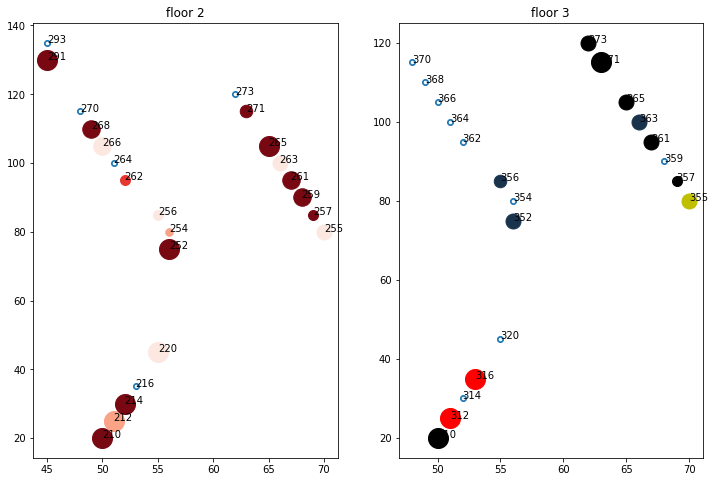

In [234]:
# to hold the coordinates of the offices of the 3rd floor
x2 = [50,51,52,53,55,56,56,55,52,51,50,49,48,70,69,68,67,66,65,63,62,45,45]
y2 = [20,25,30,35,45,75,80,85,95,100,105,110,115,80,85,90,95,100,105,115,120,130,135]

# to hold the coordinates of the offices of the 3rd floor
x3 = [50,51,52,53,55,56,56,55,52,51,50,49,48,70,69,68,67,66,65,63,62]
y3 = [20,25,30,35,45,75,80,85,95,100,105,110,115,80,85,90,95,100,105,115,120]

# to hold the office number of the offices in the map
floor2_layout = [210,212,214,216,220,252,254,256,262,264,266,268,270,255,257,259,261,263,265,271,273,291,293]
floor3_layout = [310,312,314,316,320,352,354,356,362,364,366,368,370,355,357,359,361,363,365,371,373]

# to plot notes about room number
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
ax1.plot(x2, y2, marker = 'o', ls='')
ax1.title.set_text('floor 2')
ax2.plot(x3,y3, marker = 'o', ls='')
ax2.title.set_text('floor 3')

for j, txt in enumerate(i2):
    ax1.annotate(txt, (x2[j], y2[j]))
    
for j, txt in enumerate(i3):
    ax2.annotate(txt, (x3[j], y3[j]))

# to hold information about happiness of position
    ## 1 - happy, got 1st choice -> green
    ## 2 - middle, got 2nd choice -> yellow
    ## 3 - unhappy, got third choice -> red
    ## 4 - suicidal, no choice -> black
#h2 = [1,2,4,3,2,1,1,2,2,4,2,4,1,1,3,2,3,4,1,1,3,3,4]

#h3 = [1,2,4,3,2,1,1,2,2,4,2,4,1,1,3,3,4,1,3,3,4]

h2 = get_ordered_happiness_profs(room_assignment, floor2_layout)[0]
h3 = get_ordered_happiness_profs(room_assignment, floor3_layout)[0]

distHap_floor2 = 5*np.array(get_ordered_distHapiness_affinity(Distance, prof_list_2, floor2_layout))
distHap_floor3 = 5*np.array(get_ordered_distHapiness_affinity(Distance, prof_list_3, floor3_layout))

distHap_floor2_list = get_ordered_distHapiness_affinity(Distance, prof_list_2, floor2_layout)
distHap_floor3_list = get_ordered_distHapiness_affinity(Distance, prof_list_3, floor3_layout)


# to count for outcome stat viz
first_choice, second_choice, third_choice, no_choice = 0,0,0,0


# to display happiness of assignment of assigned profs
for n in range(len(h2)):
    if h2[n] == 1:
        ax1.plot(x2[n], y2[n], c= (0.99, 0.91, 0.88), marker='o', markersize = distHap_floor2[n])
        first_choice += 1
    elif h2[n] == 2:
        ax1.plot(x2[n], y2[n], c=(0.98, 0.64, 0.53), marker='o', markersize = distHap_floor2[n])
        second_choice += 1
    elif h2[n] == 3:
        ax1.plot(x2[n], y2[n], c= (0.90, 0.22, 0.19), marker='o', markersize = distHap_floor2[n])
        third_choice += 1
    elif h2[n] == 4:
        ax1.plot(x2[n], y2[n], c=(0.47, 0.03, 0.07), marker='o', markersize = distHap_floor2[n])
        no_choice += 1
    elif h2[n] == 0:
        ax1.plot(x2[n], y2[n], c='white', marker='o', markersize = distHap_floor2[n])
    else:
        print("ERR1")
        
# to display happiness of assignment of assigned profs
for n in range(len(h3)):
    if h3[n] == 1:
        ax2.plot(x3[n], y3[n], c= (0.1,0.2,0.3), marker='o', markersize = distHap_floor3[n])
        first_choice += 1
    elif h3[n] == 2:
        ax2.plot(x3[n], y3[n], c='y', marker='o', markersize = distHap_floor3[n])
        second_choice += 1
    elif h3[n] == 3:
        ax2.plot(x3[n], y3[n], c='r', marker='o', markersize = distHap_floor3[n])
        third_choice += 1
    elif h3[n] == 4:
        ax2.plot(x3[n], y3[n], c='black', marker='o', markersize = distHap_floor3[n])
        no_choice += 1
    elif h3[n] == 0:
        ax2.plot(x3[n], y3[n], c='white', marker='o', markersize = distHap_floor3[n])
    else:
        print("ERR2")

all_choice = first_choice + second_choice + third_choice + no_choice
prox_1 = list(map(math.floor,distHap_floor2_list+distHap_floor3_list)).count(1)
prox_2 = list(map(math.floor,distHap_floor2_list+distHap_floor3_list)).count(2)
prox_3 = list(map(math.floor,distHap_floor2_list+distHap_floor3_list)).count(3)
prox_4 = list(map(math.floor,distHap_floor2_list+distHap_floor3_list)).count(4)
print('Number of people who are on average less than 2 distance units away from their affinities: ', prox_1)
print('Number of people who are on average between 2 and 3 distance units away from their affinities: ', prox_2)
print('Number of people who are on average between 3 and 4 distance units away from their affinities: ', prox_3)
print('Number of people who are on average 4 or more distance units away from their affinities: ', prox_4)
print("Percentage of professors that got their FIRST office choice: "+ str(first_choice/all_choice))
print("Percentage of professors that got their SECOND office choice: "+ str(second_choice/all_choice))
print("Percentage of professors that got their THIRD office choice: "+ str(third_choice/all_choice))
print("Percentage of professors that did not get an office of choice: "+ str(no_choice/all_choice))
# to overlap image with floorplan and coodinates
#im = plt.imread('/Users/Max/Downloads/floor_plan_2.png')
#implot = plt.imshow(im)




#ax1.xlim(0, 100)
#plt.show(

In [221]:
list(map(math.floor,distHap_floor2_list+distHap_floor3_list))

[4,
 4,
 4,
 0,
 4,
 4,
 1,
 2,
 2,
 0,
 3,
 3,
 0,
 3,
 2,
 3,
 3,
 3,
 4,
 2,
 0,
 4,
 0,
 4,
 4,
 0,
 4,
 0,
 3,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 3,
 2,
 0,
 3,
 3,
 3,
 4,
 3]

In [210]:
math.floor(5.5)

5

In [58]:
room_assignment_dict

{210: {'Happiness': 4, 'Profs': 29},
 212: {'Happiness': 4, 'Profs': 29},
 214: {'Happiness': 4, 'Profs': 29},
 216: {'Happiness': 4, 'Profs': 29},
 220: {'Happiness': 4, 'Profs': 29},
 252: {'Happiness': 4, 'Profs': 29},
 254: {'Happiness': 4, 'Profs': 29},
 255: {'Happiness': 4, 'Profs': 29},
 256: {'Happiness': 4, 'Profs': 29},
 257: {'Happiness': 4, 'Profs': 29},
 259: {'Happiness': 4, 'Profs': 29},
 261: {'Happiness': 4, 'Profs': 29},
 262: {'Happiness': 4, 'Profs': 29},
 263: {'Happiness': 4, 'Profs': 29},
 264: {'Happiness': 4, 'Profs': 29},
 265: {'Happiness': 4, 'Profs': 29},
 266: {'Happiness': 4, 'Profs': 29},
 268: {'Happiness': 4, 'Profs': 29},
 270: {'Happiness': 4, 'Profs': 29},
 271: {'Happiness': 4, 'Profs': 29},
 273: {'Happiness': 4, 'Profs': 29},
 291: {'Happiness': 4, 'Profs': 29},
 293: {'Happiness': 4, 'Profs': 29},
 310: {'Happiness': 4, 'Profs': 29},
 312: {'Happiness': 4, 'Profs': 29},
 314: {'Happiness': 4, 'Profs': 29},
 316: {'Happiness': 4, 'Profs': 29},
 

In [10]:
assign_array = np.zeros((profs,rooms))
for prof in range(profs):
    for room in range(rooms):
        assign_array[prof,room] = int(xVar[prof,room].x)

In [ ]:
assignments = pd.DataFrame(data = assign_array, columns = room_list)
assignments

In [ ]:
#### EXCEL ATTEMPT ####


writer = pd.ExcelWriter('huddle_assignment.xlsx', engine='xlsxwriter')
assignment.to_excel(writer, sheet_name='rooms')
workbook  = writer.book
huddle_assignment = writer.sheets['rooms']

room_layout = [293,291,270,268,266,264,262,256,254,252,220,216,214,212,210,272,271,265,263,261,259,257,255]
row = 22
column = 0
one_jump = [262,220,271]
two_jump = [291,252,]
for room in room_list:
    huddle_assignment.write(row,0, room_list[room])
    if room_list[room] is in one_jump:
        row += 1
    elif room_list[room] in in two_jump:
        row += 2
    row += 1
    
    
# worksheet.conditional_format('B2:AS31', {'type':     'cell',
#                                         'criteria': '>=',
#                                         'value':    50,
#                                         'format':   format1})


In [8]:
for i in range(profs):
    print(i, R_[i])

0 [220. 355. 255.]
1 [266. 363. 352.]
2 [363. 263. 355.]
3 [266. 355. 363.]
4 [356. 256. 363.]
5 [363. 352. 256.]
6 [256. 220. 263.]
7 [220. 363. 266.]
8 [263. 256. 255.]
9 [355. 256. 263.]
10 [356. 363. 256.]
11 [256. 220. 262.]
12 [363. 355. 266.]
13 [352. 255. 220.]
14 [220. 263. 255.]
15 [220. 355. 363.]
16 [266. 255. 220.]
17 [256. 220. 355.]
18 [220. 356. 256.]
19 [255. 256. 266.]
20 [352. 212. 363.]
21 [256. 254. 352.]
22 [266. 220. 263.]
23 [220. 363. 266.]
24 [255. 355. 312.]
25 [220. 363. 212.]
26 [352. 220. 266.]
27 [256. 363. 220.]
28 [352. 355. 316.]
29 [352. 255. 363.]


In [180]:
Distance.loc['210','214']

KeyError: '210'

In [ ]:
R= np.zeros((profs,rooms,num_rankings))
for i in range(profs):
    for j in range(rooms):
        for k in range(num_rankings):
            if R_[i,k]==room_list[j]:
                R[i,j,k]=1
for j in range(rooms):
    print(room_list[j], R[0,j,:])